In [22]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
import os
import pickle
import string
import time
import logging
import numpy as np
import importlib

In [3]:
from ClusterTrellis import run_experiments as rpe
from ClusterTrellis import HierarchicalTrellis
from ClusterTrellis.trellis_node import TrellisNode

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 8)

import matplotlib as mpl
from matplotlib import rcParams
from matplotlib.colors import Normalize
import matplotlib.cm as cm
from matplotlib.colors import LogNorm
from matplotlib import ticker
from matplotlib import colors
from matplotlib.patches import Ellipse
from matplotlib import gridspec

import matplotlib
matplotlib.rc('font',**{'family':'serif','serif':['Times']})
matplotlib.rc('text', usetex=True) 
matplotlib.rcParams.update({'font.size': 10})

In [5]:
from ClusterTrellis.utils import get_logger
logger = get_logger(level=logging.WARNING)

# General remarks

The Hierarchical Cluster Trellis data structure and algorithms to calculate the partition function and MAP hierarchies are introduced in https://arxiv.org/abs/2002.11661

To run the Cluster Trellis on a new model, define the get_energy_of_split and compute_map_features methods in the ModelNode class below. In particular,  get_energy_of_split represents the potential function $\psi$ introduced in the paper, describing the compatibility of a pair of sibling nodes in a hierarchy $H$.

The energy function $\psi$ for a pairwise splitting should be written in terms of the map_features and model_params. Thus, compute_map_features is an auxiliary function to calculate features of internal vertices in the trellis. The current implementation assumes that the model parameters are the same for every vertex in the trellis.

- map_features : list, where each entry is a list with the model features/values for each vertex of a dataset. In particular, we initialize the algorithm with the leaves_features list as [feature1, feature2, ... , featureN]. E.g. for Ginkgo this is [momentum, invariant mass] for each leaf.

- model_params : dictionary with the model parameters.



# Interfacing your Own Model

In [6]:
class ModelNode(TrellisNode):
    """Class to define the node pairwise splitting energy and calculate node features for a given model """

    def __init__(self,
                 model_params,
                 elements = None,
                 children = None,
                 map_features = None):
        TrellisNode.__init__(self, model_params, elements, children, map_features)


    def get_energy_of_split(self, a_node, b_node):
        """Model energy function.
        Args: sibling nodes
        returns: model pairwise splitting energy
        """


        E_split = ...
        
        

        return E_split


    def compute_map_features(self, a_node, b_node):
        """Auxiliary method to get the parent's vertex features. This is model dependent. In Ginkgo these are the momentum and   
        parent invariant mass.
        Args: sibling nodes
        returns: list where each entry is a parent feature, e.g. [feature1, feature2, ..., featureN]]
        """
        feature1= ...
        feature2= ...
        featureN= ...
        
        map_features =  [feature1,feature2,..., featureN]

        return map_features

# Example: Interfacing on Ginkgo

In [7]:
# from ginkgo.likelihood_invM import split_logLH_without_non_stop_prob as split_logLH

In [6]:
"""Replace with model auxiliary scripts to calculate the energy function"""
# from ClusterTrellis import Ginkgo_likelihood as likelihood
from ginkgo import likelihood_invM as likelihood

In [7]:
class ModelNode(TrellisNode):
    """Class to define the node pairwise splitting energy and calculate node features for a given model """

    def __init__(self,
                 model_params,
                 elements = None,
                 children = None,
                 map_features = None):
        TrellisNode.__init__(self, model_params, elements, children, map_features)


    def get_energy_of_split(self, a_node, b_node):
        """Model energy function.
        Args: sibling nodes
        returns: model pairwise splitting energy
        """

        logger.debug(f"computing energy of split: {a_node, b_node}")

        split_llh = likelihood.split_logLH_with_stop_nonstop_prob(a_node.map_features,
                                           b_node.map_features,
                                           self.model_params["delta_min"],
                                           self.model_params["lam"])
        logger.debug(f"split_llh = {split_llh}")

        return split_llh


    def compute_map_features(self, a_node, b_node):
        """Auxiliary method to get the parent vertex features. This is model dependent. In Ginkgo these are the momentum and parent         invariant mass.
        Args: sibling nodes
        returns: list where each entry is a parent feature, e.g. [feature1,feature2,...]
        """
        momentum = a_node.map_features + b_node.map_features
        logger.debug(f"computing momentum for {a_node, b_node, momentum}")

        
#         logger.debug(f"computing  parent invariant mass {a_node, a_node.map_features, b_node, b_node.map_features}")
#         pP = a_node.map_features + b_node.map_features

#         """Parent invariant mass squared"""
#         tp1 = pP[0] ** 2 - np.linalg.norm(pP[1::]) ** 2
#         logger.debug(f"tp =  {tp1}")

        return momentum

## Load Datsets

In [8]:
def load_jets(filename):
    """Load truth binary trees"""
    root_dir = "/Users/sebastianmacaluso/Dropbox/Documents/Physics_projects/simulator/ginkgo/data/invMassGinkgo/"
    filename = os.path.join(root_dir, filename)
    with open(filename + ".pkl", "rb") as fd:
        Truth= pickle.load(fd, encoding='latin-1')
    return Truth

In [9]:
gt_trees = load_jets("jets_4N_10trees_40tcut_0") 

In [31]:

# for i in range(len(gt_trees)):
#     print(gt_trees[i]['logLH'])
#     print("---------")

In [32]:
gt_trees[0]['logLH']

array([-11.80794361,  -7.42099741,  -2.55419663,   0.        ,
         0.        ,   0.        ,   0.        ])

In [24]:
gt_trees[0]['logLH']

array([-11.80794361,  -7.42099741,  -2.55419663,   0.        ,
         0.        ,   0.        ,   0.        ])

In [109]:
# pR=np.asarray([19.49997996 ,13.11649767 , 8.12905824, 11.96505639])
pR=np.asarray([  1.82811666e+01,  1.11821207e+01,  8.53798272e+00,
          1.17832689e+01])
tR = pR[0] ** 2 - np.linalg.norm(pR[1::]) ** 2

In [110]:
tR

-2.5813459891388106

In [106]:
np.sum([[ 1.21881391e+00,  1.93437737e+00, -4.08924238e-01,
          1.81787818e-01],
        [ 1.82811666e+01,  1.11821207e+01,  8.53798272e+00,
          1.17832689e+01]],axis=0)

array([19.49998051, 13.11649807,  8.12905848, 11.96505672])

In [14]:
# likelihood.enrich_jet_logLH(gt_trees[5], dij=False)

In [11]:
label = "Trellis"; plotDir = "../experiments/plots/"

In [12]:
def load_jets(filename):
    """Load truth binary trees"""
    root_dir = "../data/"
    filename = os.path.join(root_dir, filename)
    with open(filename + ".pkl", "rb") as fd:
        Truth= pickle.load(fd, encoding='latin-1')
    return Truth

In [13]:
gt_trees = load_jets("truth_5")

In [14]:
len(gt_trees)

10

# Run Exact trellis on truth trees step by step

Replace leaves_features and model_params with current model values

In [15]:
"""Find MAP hierarchy and partition function """
times=[]
MAP = []
for i in range(2):
    
    """Dataset"""
    data_params = gt_trees[i]
    
    """Number of elements"""
    N=len(data_params['leaves'])

    """Replace with leaves features for current model"""
#     leaves_features =[ [data_params['leaves'][i],0] for i in range(N)]
    leaves_features =[ data_params['leaves'][i] for i in range(N)]
    
    """Replace with current model parameters
    """
    model_params ={}
    model_params["delta_min"] = float(data_params['pt_cut'])
    model_params["lam"]= float(data_params['Lambda'])
    
    startTime = time.time()
    
    """ Create trellis"""
    a_trellis = HierarchicalTrellis.HierarchicalTrellis()
    a_trellis.create_from_leaves(leaves_features, 
                                                  model_params, 
                                                  NodeClass = ModelNode)
    
    """Compute MAP (MLE), partition function Z"""
    map_energy, Z , Ntrees= np.float64(a_trellis.compute_map_tree())
    endTime = time.time() - startTime
    
    times.append(endTime)
    MAP.append(map_energy)

In [16]:
print("Maximum likelihood hierarchy = ",  MAP)
print("times = ",times)

Maximum likelihood hierarchy =  [-29.013852702765107, -27.32154668236919]
times =  [0.02909994125366211, 0.026021718978881836]


# Run Trellis and fill results with MAP and Partition Function Z 

Replace leaves_features and model_params with current model values

In [10]:
def runTrellisOnly(gt_trees, 
               NleavesMin =3, 
               NleavesMax= 4, 
               MaxNjets = 1
              ):
    
    """Create and fill the trellis for a given set of leaves
    Args: 
    gt_trees : truth level  trees.
    NleavesMin: minimum number of leaves to select  trees
    NleavesMax: maximum number of leaves to select  trees
    MaxNjets: maximum number of trees to run the trellis code.
    
    Returns:
    results: dictionary with the following {key:values}
                Z: partition functions,
                trellis_MLE: MAP hierarchy, 
                RunTime: time for each tree
                totJets": total number of trees
                gt_llh: truth level trees llh
 
    """
    
    """ Keep only trees with leaves between NleavesMin and NleavesMax"""
    smallJetIndex =[i for i,gt_tree in enumerate(gt_trees)  if NleavesMin<=len(gt_tree["leaves"])<NleavesMax]
            
    
    results = {"Z":[], "trellis_MLE":[], "RunTime":[], "Ntrees":[]}
    
    if len(smallJetIndex)>0:
        
        GT_trees = np.asarray(gt_trees)[smallJetIndex]
        
        """ Total number of trees to run the trellis"""
        totTrees = np.min([MaxNjets,len(smallJetIndex)])

        results["totTrees"] = totTrees
        results["Nleaves"] = [len(GT_trees[m]["leaves"]) for m in range(totTrees)]
        results["gt_llh"]= [np.sum(GT_trees[m]["logLH"]) for m in range(totTrees)]

        for m in range(totTrees):

            if m%50==0:
                print("Creating trellis for jet #",m)
                
            startTime = time.time()
            
            data_params = GT_trees[m]
            N=len(data_params['leaves'])
            
            """Replace with current model parameters"""
#             leaves_features =[ [data_params['leaves'][i],0] for i in range(N)]
            leaves_features =[ data_params['leaves'][i] for i in range(N)]
            model_params ={}
            model_params["delta_min"] = float(data_params['pt_cut'])
            model_params["lam"]= float(data_params['Lambda'])

    
            """ Create trellis"""
            trellis = HierarchicalTrellis.HierarchicalTrellis()
            trellis.create_from_leaves(leaves_features, 
                                                          model_params, 
                                                          NodeClass = ModelNode)

            """Compute MAP (MLE), partition function Z"""
            map_energy, Z , Ntrees= np.float64(trellis.compute_map_tree())
            
#             """ Create and fill the trellis"""
#             trellis, Z, map_energy, Ntrees,  totTime = rpe.compare_map_gt_and_bs_trees(GT_trees[m], 
#                                                                                                                                          ModelNode,
#                                                                                                                                          leaves_features,
#                                                                                                                                          model_params)

            results["Z"].append(Z)
            results["trellis_MLE"].append(map_energy)
            results["Ntrees"].append(Ntrees)

            endTime = time.time() - startTime
            results["RunTime"].append(endTime)

    else:
        print("There are no jets in the dataset with the required number of leaves ")

    return results, trellis

In [11]:
# gt_trees = load_jets("truth_3")

In [12]:
NleavesMin =4
NleavesMax=NleavesMin+1
MaxNjets = 10

start = time.time()
results10, trellis10 =  runTrellisOnly(gt_trees, 
               NleavesMin =NleavesMin, 
               NleavesMax= NleavesMax, 
               MaxNjets = MaxNjets)

print("Total time = ", time.time() - start)

Creating trellis for jet # 0
Total time =  0.08533811569213867


In [13]:
results10["Z"], results10["trellis_MLE"]

([-20.36740902612064,
  -22.201623310971783,
  -19.76396758454844,
  -22.31047189908529,
  -20.965011849841904,
  -21.944437551696968,
  -21.79594121574323,
  -21.52299166539508,
  -23.047427397135003,
  -21.080065367221938],
 [-21.009005023540155,
  -22.563590947074964,
  -19.89523001965739,
  -23.418847563991513,
  -22.15030362209494,
  -22.359103121444694,
  -22.855011698188946,
  -22.13353952457124,
  -24.514670910040298,
  -21.29224629388942])

In [20]:
save=False
outdir = "../experiments/"
if save:
    out_filename = os.path.join(outdir, "TrellisExactTruth_"+str(NleavesMin)+"_"+str(len(gt_trees))+"_jets.pkl")
    with open(out_filename, "wb") as f:
        pickle.dump(results10, f, protocol=2)

In [21]:
NleavesMin =9
NleavesMax=10

load=False
outdir = "../experiments/"
if load:
    in_filename = os.path.join(outdir, "TrellisExactTruth_"+str(NleavesMin)+"_"+str(len(gt_trees))+"_jets.pkl")
    with open(in_filename, "rb") as fd:
        results = pickle.load(fd, encoding='latin-1')

## Brute Force Comparison 

In [14]:
def find_Ntrees(Nleaves):
    Tot=1
    for k in range(2*Nleaves-3,1,-2):
        Tot*=k
    return Tot

In [15]:
Z_brute_force, MLE_brute_force = [],[]
for gt_jet in gt_trees[0:10]:
    from ClusterTrellis.topologies import build_jetTrees
    all_topologies = build_jetTrees(leaves=gt_jet['leaves'],
                             propagate_values_up=0,
                            Ntopologies= find_Ntrees(len(gt_jet['leaves'])),
                             max_nodes= 2**(len(gt_jet['leaves']))+10,
                             min_invM=gt_jet['pt_cut'],
                             Lambda=gt_jet['Lambda'],
                             LambdaRoot=gt_jet['LambdaRoot'])

    all_nodes=[]
    all_topologies.build_topologies(all_topologies.clusters[all_topologies.root], all_nodes)

    all_trees = all_topologies.topologies

    _Z, _MAP = all_topologies.tree_log_likelihood(all_trees) 
    Z_brute_force.append(_Z)
    MLE_brute_force.append(_MAP)

In [16]:
all_trees

[[(frozenset({1}), frozenset({0, 2, 3})),
  (frozenset({2}), frozenset({0, 3})),
  (frozenset({3}), frozenset({0}))],
 [(frozenset({1}), frozenset({0, 2, 3})),
  (frozenset({3}), frozenset({0, 2})),
  (frozenset({2}), frozenset({0}))],
 [(frozenset({1}), frozenset({0, 2, 3})),
  (frozenset({2, 3}), frozenset({0})),
  (frozenset({3}), frozenset({2}))],
 [(frozenset({2}), frozenset({0, 1, 3})),
  (frozenset({1}), frozenset({0, 3})),
  (frozenset({3}), frozenset({0}))],
 [(frozenset({2}), frozenset({0, 1, 3})),
  (frozenset({3}), frozenset({0, 1})),
  (frozenset({1}), frozenset({0}))],
 [(frozenset({2}), frozenset({0, 1, 3})),
  (frozenset({1, 3}), frozenset({0})),
  (frozenset({3}), frozenset({1}))],
 [(frozenset({3}), frozenset({0, 1, 2})),
  (frozenset({1}), frozenset({0, 2})),
  (frozenset({2}), frozenset({0}))],
 [(frozenset({3}), frozenset({0, 1, 2})),
  (frozenset({2}), frozenset({0, 1})),
  (frozenset({1}), frozenset({0}))],
 [(frozenset({3}), frozenset({0, 1, 2})),
  (frozenset({

## Sanity Check with Trellis

In [17]:
np.subtract(Z_brute_force , results10["Z"])

array([-8.00059006e-08, -8.82974796e-08, -8.84532625e-08, -8.72517418e-08,
       -8.46937915e-08, -8.82182469e-08, -8.68473364e-08, -8.76777584e-08,
       -8.78992346e-08, -8.83285267e-08])

In [18]:
np.subtract(MLE_brute_force , results10["trellis_MLE"])

array([-8.85081128e-08, -8.83601281e-08, -8.86244216e-08, -8.64858904e-08,
       -8.30019040e-08, -8.82742803e-08, -8.61592184e-08, -8.83960780e-08,
       -8.78606166e-08, -8.84436915e-08])

## Reevaluate jet likelihood

In [11]:
from ginkgo.likelihood_invM import reevaluate_jet_logLH

In [30]:
def load_jets(filename):
    """Load truth binary trees"""
    root_dir = "/Users/sebastianmacaluso/Dropbox/Documents/Physics_projects/simulator/ginkgo/data/invMassGinkgo/"
    filename = os.path.join(root_dir, filename)
    with open(filename + ".pkl", "rb") as fd:
        Truth= pickle.load(fd, encoding='latin-1')
    return Truth

In [31]:
gt_trees = load_jets("jets_4N_10trees_40tcut_0") 

In [81]:
jet = gt_trees[0]
# delta_min= jet['pt_cut']
# Lambda = jet['Lambda']
Lambda = 2
delta_min= 10
new_jet = reevaluate_jet_logLH(jet, delta_min=delta_min, Lambda = Lambda)

In [82]:
jet['logLH']

array([-11.80794361,  -7.42099741,  -2.55419663,   0.        ,
         0.        ,   0.        ,   0.        ])

In [83]:
new_jet['logLH']

array([-14.29255623,  -7.23057103,  -2.75006308,   0.        ,
         0.        ,   0.        ,   0.        ])

In [86]:
# jet

In [87]:
# new_jet

## Recluster tree with random permutations of left/right

In [94]:
from ginkgo.auxFunctions import traverse

In [95]:
gt_tree = gt_trees[0]

In [103]:
 tree, content ,leaves,  _,_ =_traverse( gt_tree['root_id'],
        gt_tree['content'],
        jetTree=gt_tree['tree'],
        Nleaves=len(gt_tree['leaves'])
                      , dendrogram=False  )

TypeError: _traverse_flipLR() missing 1 required positional argument: 'leaves'

In [89]:
tree = np.asarray(tree).reshape(-1, 2)
content = np.asarray(content)


In [90]:
tree, content

(array([[ 1,  6],
        [ 2,  5],
        [ 3,  4],
        [-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1]]),
 array([[401.1234224 , 230.94010768, 230.94010768, 230.94010768],
        [312.52120003, 175.71738553, 175.3636741 , 189.75188718],
        [302.44544199, 170.45555686, 169.89086292, 183.13487002],
        [ 70.00143919,  39.09508963,  39.65522338,  42.40582205],
        [232.44400279, 131.36046724, 130.23563955, 140.72904797],
        [ 10.07576437,   5.26183222,   5.47281472,   6.617021  ],
        [ 88.60222237,  55.22272214,  55.57643358,  41.1882205 ]]))

In [88]:
# gt_tree

In [89]:
# gt_trees[0]

### Permutations

In [28]:
["12"]+['ew','w']+['12']

['12', 'ew', 'w', '12']

In [57]:
all_trees[0]

[(frozenset({1}), frozenset({0, 2})), (frozenset({2}), frozenset({0}))]

In [64]:
tree_permutations=[]
all_topologies.invariant_permutations(all_trees[0],tree_permutations)

In [65]:
tree_permutations

[[(frozenset({0, 2}), frozenset({1})), (frozenset({2}), frozenset({0}))],
 [(frozenset({1}), frozenset({0, 2})), (frozenset({2}), frozenset({0}))],
 [(frozenset({0, 2}), frozenset({1})), (frozenset({0}), frozenset({2}))],
 [(frozenset({1}), frozenset({0, 2})), (frozenset({0}), frozenset({2}))]]

In [42]:
set([1,2,3,3])

{1, 2, 3}

In [66]:
import pyro

In [67]:
globals()["Bernoulli_dist"] = pyro.distributions.Bernoulli(probs=0.5)

In [72]:
for _ in range(10):
    print(pyro.sample('a',Bernoulli_dist ) )

tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(0.)
tensor(0.)
tensor(1.)
tensor(0.)
tensor(1.)


In [73]:
import torch

In [83]:
if torch.tensor(1.)==True:
    print('a')

a


# Likelihood plots

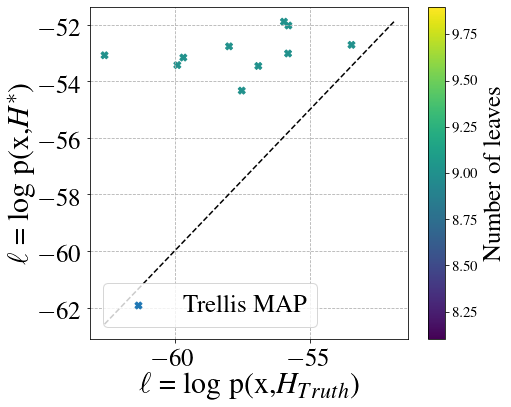

In [22]:
fig2, (axes) = plt.subplots(nrows=1, ncols=1)
fig2.set_size_inches(6,5)
plt.tight_layout(pad=0.4, w_pad=5, h_pad=1.0)
markersize = 50

for i in range(1):
    
     
    x = np.linspace(min(results["gt_llh"]), max(results["trellis_MLE"]), 1000)
    cl1 = axes.scatter(np.asarray(results["gt_llh"]), np.asarray(results["trellis_MLE"]), c=np.asarray(results["Nleaves"]) ,  marker="X", s=markersize, label="Trellis MAP")
    
    cb = fig2.colorbar(cl1, ax=axes, fraction=0.15, shrink=1.0, aspect=20)
    cb.set_label(label="Number of leaves", size=25)
    cb.ax.tick_params(labelsize=15)
    

    axes.tick_params(labelsize=25) 
    axes.plot(x, x, color="black", linestyle='--')
    axes.grid(which='both', axis='both', linestyle='--')
    axes.legend(loc='lower left', fontsize=25)
    
    axes.set_xlabel(r"$ \ell $ = log p(x,$H_{Truth}$)", fontsize=30)
    axes.set_ylabel(r" $ \ell $ = log p(x,$H^*$)", fontsize=30)

saveFig=False    
if saveFig:
    fig2.savefig(plotDir+"llhScatter.pdf", bbox_inches='tight')
    
plt.show()

# Posterior distribution from sampling

Calculate  samples from the exact true posterior without enumerating all possible hierarchies.
Instructions:

1- Replace gt5_jets with the loaded datasets (The algorithm will sample hierarchies for the first dataset loaded).

2- Define Nsamples, NleavesMin and NleavesMax as the number of hierarchies to sample, and the minimum (including) and maximum (excluding) number of elements of the dataset to select.

In [23]:
def posteriorDist( gt_trees, 
                  Nsamples = 1,
                  NleavesMin =9,
                  NleavesMax=10, 
                  MaxNjets = 1):
    """Sample trees to build the posterior distribution"""

    """Create and fill trellis"""
    results, trellis =  runTrellisOnly(gt_trees, 
               NleavesMin =NleavesMin, 
               NleavesMax= NleavesMax, 
               MaxNjets = MaxNjets)
    
    
    """Sampling"""
    treedist = np.asarray(trellis.sample_trees(trellis.root, Nsamples))
    
    treedistLH = np.exp(treedist)
    
    return results, treedist, treedistLH

In [24]:
def savePosterior(treedist,resultsPost, Nsamples = 1, NleavesMin=1):
    outdir = "../experiments/"
    out_filename = os.path.join(outdir, "Posterior"+label+"_Samples_"+str(Nsamples)+"_"+str(NleavesMin)+".pkl")
    
    with open(out_filename, "wb") as f:
        pickle.dump((treedist,resultsPost), f, protocol=2)

In [25]:
def loadPosterior(Nsamples = None,NleavesMin=None):

    outdir = "../experiments/"

    in_filename = os.path.join(outdir, "Posterior"+label+"_Samples_"+str(Nsamples)+"_"+str(NleavesMin)+".pkl")
    with open(in_filename, "rb") as fd:
        treedist,resultsPost = pickle.load(fd, encoding='latin-1')
    return  treedist,resultsPost

In [26]:
"""Load dataset"""
gt5_jets = load_jets("truth_5")

In [27]:
""" Define the number of hierarchies to sample, and the minimum (including) and maximum (excluding) number of elements of the dataset. The algorithm will sample hierarchies for the first dataset loaded"""

Nsamples = 20000
NleavesMin =5
NleavesMax=6

resultsPost , treedist, treedistLH = posteriorDist(gt5_jets[2::],
                  Nsamples = Nsamples,
                  NleavesMin =NleavesMin,
                  NleavesMax=NleavesMax, 
                  MaxNjets = 1)

Creating trellis for jet # 0


In [28]:
savePosterior(treedist,resultsPost, Nsamples = Nsamples, NleavesMin=NleavesMin)

In [29]:
treedist, resultsPost =  loadPosterior(Nsamples = Nsamples,  NleavesMin=NleavesMin)

### Plots

In [30]:
def perBinLH(treedist, edges):
    """ Add the likelihood of all trees that fall within a bin"""
    treedistLH = np.exp(treedist)
    binLH = []
    for i in range(len(edges)-1):
        temp=0
        for m in range(len(treedist)):
            if edges[i]<treedist[m]<edges[i+1]:
                temp+=treedistLH[m]
        binLH.append(temp)
        
    return np.asarray(binLH)

In [31]:
def posteriorHist(treedist, resultsPost, bins=10):
    
    fig2 = plt.figure()
    gs = fig2.add_gridspec(2, 1, height_ratios=[8, 0.9]) 
    # gs = gridspec.GridSpec(2, 1, height_ratios=[1, 3]) 

    fig2, (axes) = plt.subplots(nrows=1, ncols=1)
    fig2.set_size_inches(6, 6)
    plt.tight_layout(pad=0.4, w_pad=5, h_pad=5.0)
    markersize = 200
     
    axes0 = plt.subplot(gs[0])    
    
    pdf, edges = np.histogram(treedist, density=True, bins=bins)
#     print(pdf)    
    edgesCenter = [(edges[i+1]+edges[i])/2 for i in range(len(edges)-1)]

    err = np.sqrt(pdf/len(treedist)/(bins[-1]-bins[-2]))

    axes0.errorbar(edgesCenter, pdf, marker="o", yerr=err, color = "black",linestyle ="",  drawstyle = 'steps-mid', label="Sampled")

    
    
    LHset = np.asarray(list(set(treedist)))
    newData = perBinLH(LHset, edges)/np.exp(resultsPost["Z"])

    
    axes0.bar(edgesCenter,newData/ (bins[-1]-bins[-2]),width = (bins[-1]-bins[-2]), color="green", alpha=0.8, label="Expected")
    
    axes0.axvline(resultsPost["gt_llh"][0], color='red', linestyle='dashed', linewidth=3, label = "Ground Truth")
    
    axes0.grid(which='both', axis='both', linestyle='--')
    axes0.tick_params(labelsize=25) 
    axes0.legend(loc='upper left', fontsize=25)
    axes0.set_xlabel(r" $ \ell $ = log p(x,H)", fontsize=30)
    axes0.set_ylabel(r"p($\ell \,|$ x) ", fontsize=30)


    saveFig=True    
    if saveFig:
        fig2.savefig(plotDir+"posteriorSample"+str(Nsamples)+"_"+str(NleavesMin)+"_"+str(NleavesMax)+".pdf", bbox_inches='tight')
    
#     plt.show()

<Figure size 576x576 with 0 Axes>

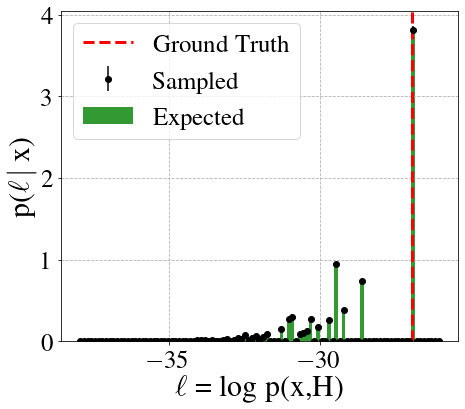

In [32]:
posteriorHist(treedist,  resultsPost, bins = np.linspace(-38,-26,num =100))

## Tree multiplicity vs Number of leaves

In [33]:
def Ntrees(Nleaves):
    Tot=1
    for k in range(2*Nleaves-3,1,-2):
        Tot*=k
    return Tot

In [34]:
for m in range(3,20):
    print(m, "elements | ", Ntrees(m), "hierarchies")

3 elements |  3 hierarchies
4 elements |  15 hierarchies
5 elements |  105 hierarchies
6 elements |  945 hierarchies
7 elements |  10395 hierarchies
8 elements |  135135 hierarchies
9 elements |  2027025 hierarchies
10 elements |  34459425 hierarchies
11 elements |  654729075 hierarchies
12 elements |  13749310575 hierarchies
13 elements |  316234143225 hierarchies
14 elements |  7905853580625 hierarchies
15 elements |  213458046676875 hierarchies
16 elements |  6190283353629375 hierarchies
17 elements |  191898783962510625 hierarchies
18 elements |  6332659870762850625 hierarchies
19 elements |  221643095476699771875 hierarchies
